In [2]:
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel


import torch
from torch import nn
import numpy as np

import pickle
from tqdm import tqdm


from collections import Counter
import matplotlib.pyplot as plt

import logging
logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)

## GPT-2 Usage Notes

 - Use `past` in GPT-2 computations: <br> `past` is the ouput of a GPT-2 `model()` call and also its input; put `past` of previous output into next input to save computations
 
 - logit(p) = log(p/1-p) -> sigmoid(logit(p)) = p <br> can just use softmax (equiv to sigmoid for multivariate) and log on top
 
 - use prob_tensor.gather(dim, index_tensor) to extract probabilities of occurred words from distributions (tensors must be same dimensionality!) <br> => seems like ouput of GPT-2 is already words' probs extracted (but then do sigmoid instead of softmax)
 

In [9]:
# tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

# remove when training
# model.eval()
model.train()

I0226 17:15:28.877851 140415505782592 configuration_utils.py:254] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-config.json from cache at /home/valentin/.cache/torch/transformers/4be02c5697d91738003fb1685c9872f284166aa32e061576bbe6aaeb95649fcf.699bbd1c449e9861456f359d6daa51bd523ac085b4b531ab0aad5a55d091e942
I0226 17:15:28.880422 140415505782592 configuration_utils.py:290] Model config GPT2Config {
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 0,
  "do_sample": false,
  "embd_pdrop": 0.1,
  "eos_token_ids": 0,
  "finetuning_task": null,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_epsilon": 1e-05,
  "length_penalty": 1.0,
  "max_length": 20,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_positions": 1024,
  "num_beams": 1,
  "

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Laye

---

## Tokenize and Convert to IDs with GPT-2 Tokeniser

In [ ]:
with open("../../../w3c-emails/emails.pkl", "rb") as handle:
#     emails = pickle.load(handle)
    mail_bodies_raw = [e.body_raw for e in pickle.load(handle)]

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
with torch.no_grad():
    ids = [torch.tensor(tokenizer.encode(body_str, add_special_tokens=True)) 
           for body_str in tqdm(mail_bodies_raw)]
    
    with open("GPT2_email_token_ids.pkl", "wb") as handle:
        pickle.dump(ids, handle)

---
(start from here once tokenisation done)

In [3]:
with open("GPT2_email_token_ids.pkl", "rb") as handle:
    ids = pickle.load(handle)

In [10]:
def cut_up(mail_tensor, n=511, k=20):
    if mail_tensor.shape[0] <= n:
        return (mail_tensor, )
    
    unfolded = mail_tensor.unfold(0, n, n-k)
    covered = unfolded.shape[0]-unfolded.shape[1]
   
    return tuple(v for v in unfolded) + (mail_tensor[covered:],)


# same as 
def split_crude(mail_tensor, n=1024):
    if mail_tensor.shape[0] <= n:
        return mail_tensor.unsqueeze(0)
    
    split_up = mail_tensor.split(n)
    if split_up[-1].shape != split_up[0].shape:
        return torch.stack(split_up[:-1])
    return torch.stack(split_up)

In [ ]:
# remove when training
with torch.no_grad():
    for mail_token_ids in ids[:50]:
        print(mail_token_ids.shape)
        token_batch = split_crude(mail_token_ids)
        print(token_batch.shape)
        
        loss, logits, _ = model(token_batch, labels=token_batch)#, past=past)
        probs = logits.softmax(-1)
        word_probs = probs.gather(-1, token_batch.unsqueeze(-1))
        email_prob = word_probs.log2().sum()

        
        print("------")
        print(email_prob)
        print(word_probs.squeeze(-1)[0, :10])       
        print("\n\n")

In [ ]:
# optimizer = torch.optim.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

opt = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))




# Train and evaluate using tf.keras.Model.fit()
history = model.fit(train_dataset, epochs=2, steps_per_epoch=115,
                    validation_data=valid_dataset, validation_steps=7)

In [ ]:
first = split_crude(ids[0])
model(first)[-1]

---
## FOR TRAINING USE

`python3 run_language_modeling.py --output_dir=output --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_file --line_by_line`

 - `--line_by_line` indicates one sample per line to spearate e-mails, `"\n"` inside e-mails converted to `" "`
 - perhaps use `--block_size=128/256/512` (rather than GPT-2's default of 1024) -> loose fewer tokens at the ends of long emails
 - 
--- 

## Domain-Adapt GPT-2 to W3C E-mails

 - pre-train an instance of GPT-2 on entire (subset of) w3c-email corpus <br>
   -> will reduce perplexity and thus increase sensitivity of LMs
 - use this LM as starting point to train personalised LMs 
 - also reserve a test set? -> i.e. some e-mails which no custom-trained LM has seen before

---
# PREPARING TRAINING

 - [x] get authors with certain ranks according to their frequency of authoring
 - [ ] collect e-mails from authors and put into their own files
 - [ ] split train and test sets 

In [ ]:
def senders_by_ranks(emails, ls_of_ranks):
    sndr_cnts = Counter(e.sender for e in emails)
    ranks_sndr = {r:s for r, (s, c) in enumerate(sndr_cnts.most_common())}
    
    for r in ls_of_ranks:
        cur_s = ranks_sndr[r]
        yield [m for m in emails if m.sender == cur_s]

def emails_to_dataset():
    ranks = [2**i for i in range(10)]
    
    

In [3]:
with open("../../../w3c-emails/emails.pkl", "rb") as handle:
    emails = pickle.load(handle)
#     mail_bodies_raw = [e.body_raw for e in pickle.load(handle)]

In [15]:
emails[0].sender, emails[0].body_raw.replace("\n", "  ")

(jonathan chetwynd <jonathan@signbrowser.free-online.co.uk>,
 '      I completely agree with your statement 1 concerning the relation of graphics  in a picture being of greater significance than the icons of which it is  built.    Giotto is said to be one of the first to illustrate this point successfully  in a fresco in the Arena chapel at Padua (1305-8).  Two methods are tried.  Text is used to support individual icons, alternatively an allegorical  picture is used.  Both systems work.    One of my present concerns is how (narrative) turning points are structured  on the www. Anyone got any ideas?      jay@peepo.com    Please send us links to your favourite websites.  Our site www.peepo.com is a drive thru.  When you see a link of interest, click on it.  Move the mouse to slow down.  It is a graphical aid to browsing the www.  We value your comments.        ')

18886 143963
[1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
[1659, 1594, 1228, 1074, 716, 551, 337, 179, 88, 41]
[0.0115, 0.0111, 0.0085, 0.0075, 0.005, 0.0038, 0.0023, 0.0012, 0.0006, 0.0003]


NameError: name 'senders_by_ranks' is not defined

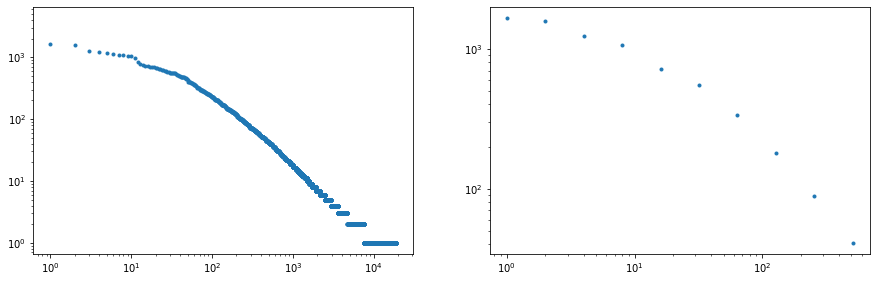

In [18]:
sndr_cnts = Counter(e.sender for e in emails)

rs, cs = list(zip(*[(r, c) for r, (_, c) in enumerate(sndr_cnts.most_common())]))

plt.figure(1, )
plt.subplot(221)
plt.loglog(rs, cs, '.')

rng = [2**i for i in range(10)]
rng_cs = [cs[i] for i in rng]

plt.subplot(222)
plt.loglog(rng, rng_cs, '.')

print(len(sndr_cnts), len(emails))
print(rng, rng_cs, [round(c/len(emails), 4) for c in rng_cs], sep="\n")



    
        
less_mails = list(senders_by_ranks(emails, rng))

In [39]:
len(less_mails)

print(len([m for s_ls in less_mails for m in s_ls])/len(emails))


less2 = list(senders_by_ranks(emails, range(1, 10)))
print(len([m for s_ls in less2 for m in s_ls])/len(emails))

0.051867493731028114
0.07836735827955794


In [41]:
sndr_body_tups = [(m_ls[0].sender,[m.body_raw for m in m_ls]) for m_ls in less_mails]